In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np
import re

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the data
def load_data(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    pairs = []
    for line in lines:
        parts = line.split("\t")
        if len(parts) >= 2:
            source = parts[0].strip().lower()
            target = parts[1].strip().lower()
            pairs.append((source, target))

    return pairs

# Tokenizer and Vocabulary
class Tokenizer:
    def __init__(self, text_list, min_freq=2):
        self.counter = Counter()
        for text in text_list:
            tokens = self.tokenize(text)
            self.counter.update(tokens)

        self.tokens = [word for word, freq in self.counter.items() if freq >= min_freq]
        self.tokens = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"] + sorted(self.tokens)
        self.token2idx = {token: idx for idx, token in enumerate(self.tokens)}
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}

    def tokenize(self, text):
        return re.findall(r'\b\w+\b', text)

    def encode(self, text):
        tokens = self.tokenize(text)
        return [self.token2idx.get(token, self.token2idx["<UNK>"]) for token in tokens]

    def decode(self, indices):
        return " ".join([self.idx2token.get(idx, "<UNK>") for idx in indices])

# Custom Dataset
class TranslationDataset(Dataset):
    def __init__(self, pairs, source_tokenizer, target_tokenizer):
        self.pairs = pairs
        self.source_tokenizer = source_tokenizer
        self.target_tokenizer = target_tokenizer

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        source, target = self.pairs[idx]
        source_encoded = [self.source_tokenizer.token2idx["<SOS>"]] + self.source_tokenizer.encode(source) + [self.source_tokenizer.token2idx["<EOS>"]]
        target_encoded = [self.target_tokenizer.token2idx["<SOS>"]] + self.target_tokenizer.encode(target) + [self.target_tokenizer.token2idx["<EOS>"]]
        return torch.tensor(source_encoded), torch.tensor(target_encoded)

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, embed_size, num_heads, num_layers, ff_hidden_dim, dropout=0.1):
        super().__init__()
        self.source_embedding = nn.Embedding(source_vocab_size, embed_size)
        self.target_embedding = nn.Embedding(target_vocab_size, embed_size)
        self.transformer = nn.Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_hidden_dim,
            dropout=dropout,
            batch_first=True,  # Ensure batch comes first
        )
        self.fc_out = nn.Linear(embed_size, target_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, source, target):
        source = self.dropout(self.source_embedding(source))
        target = self.dropout(self.target_embedding(target))

        # Generate masks for the target
        tgt_mask = self.transformer.generate_square_subsequent_mask(target.size(1)).to(device)

        # Forward pass through transformer
        output = self.transformer(src=source, tgt=target, tgt_mask=tgt_mask)
        return self.fc_out(output)


# Training and Evaluation
def train_model(model, dataloader, optimizer, criterion, epochs=1):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for source, target in dataloader:
            source, target = source.to(device), target.to(device)
            target_input = target[:, :-1]
            target_output = target[:, 1:]

            optimizer.zero_grad()

            # Pass source and target_input through the model
            output = model(source, target_input)

            # Reshape output and target_output for loss calculation
            output = output.reshape(-1, output.shape[-1])
            target_output = target_output.reshape(-1)

            loss = criterion(output, target_output)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")


def translate_sentence(model, sentence, source_tokenizer, target_tokenizer, max_len=50):
    model.eval()

    # Encode source sentence
    source_encoded = [source_tokenizer.token2idx["<SOS>"]] + source_tokenizer.encode(sentence) + [source_tokenizer.token2idx["<EOS>"]]
    source_tensor = torch.tensor(source_encoded).unsqueeze(0).to(device)  # Add batch dimension

    # Start with <SOS> token for target
    target_tensor = torch.tensor([[target_tokenizer.token2idx["<SOS>"]]]).to(device)

    for _ in range(max_len):
        # Pass source and current target tensor to the model
        output = model(source_tensor, target_tensor)

        # Get the predicted next token
        next_token = output[:, -1, :].argmax(-1).item()

        # Append the predicted token to the target sequence
        target_tensor = torch.cat([target_tensor, torch.tensor([[next_token]]).to(device)], dim=1)

        # Stop if <EOS> token is predicted
        if next_token == target_tokenizer.token2idx["<EOS>"]:
            break

    # Decode the output sequence
    translated_sentence = target_tokenizer.decode(target_tensor.squeeze(0).cpu().numpy())
    return translated_sentence.replace("<SOS>", "").replace("<EOS>", "").strip()


def collate_fn(batch):
    sources = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    sources_padded = nn.utils.rnn.pad_sequence(sources, batch_first=True, padding_value=source_tokenizer.token2idx["<PAD>"])
    targets_padded = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=target_tokenizer.token2idx["<PAD>"])

    return sources_padded, targets_padded

# Main
if __name__ == "__main__":
    # Load dataset
    pairs = load_data("/content/ukr.txt")

    # Tokenizers
    source_texts = [pair[0] for pair in pairs]
    target_texts = [pair[1] for pair in pairs]
    source_tokenizer = Tokenizer(source_texts)
    target_tokenizer = Tokenizer(target_texts)

    # Dataset and DataLoader
    dataset = TranslationDataset(pairs, source_tokenizer, target_tokenizer)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

    # Model, Optimizer, Criterion
    model = TransformerModel(len(source_tokenizer.tokens), len(target_tokenizer.tokens), embed_size=256, num_heads=8, num_layers=4, ff_hidden_dim=512).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss(ignore_index=target_tokenizer.token2idx["<PAD>"])

    # Train
    train_model(model, dataloader, optimizer, criterion, epochs=10)


Epoch [1/10], Loss: 21541.4906
Epoch [2/10], Loss: 14995.9545
Epoch [3/10], Loss: 11925.3598
Epoch [4/10], Loss: 9938.0941
Epoch [5/10], Loss: 8545.9286
Epoch [6/10], Loss: 7529.0861
Epoch [7/10], Loss: 6742.0044
Epoch [8/10], Loss: 6128.7775
Epoch [9/10], Loss: 5636.8858
Epoch [10/10], Loss: 5222.1498
Input: Hi.
Translation: <UNK>


In [23]:
# Test
test_sentence = "I've never said that."
translation = translate_sentence(model, test_sentence, source_tokenizer, target_tokenizer)
print(f"Input: {test_sentence}")
print(f"Translation: {translation}")

Input: I've never said that.
Translation: ніколи не казав що це <UNK>


In [26]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the tokenizer and model for English-to-Ukrainian translation
model_name = "Helsinki-NLP/opus-mt-en-uk"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Input text in English
input_text = "Hello, how are you?"

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt")

# Generate the translation
outputs = model.generate(**inputs)

# Decode the translation
translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Translated text:", translated_text)


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/305M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/305M [00:00<?, ?B/s]

Translated text: Привіт, як справи?


Iteration 0/500, Total Loss: 86.71176147460938
Iteration 50/500, Total Loss: 24.71931266784668
Iteration 100/500, Total Loss: 13.83083724975586
Iteration 150/500, Total Loss: 9.199455261230469
Iteration 200/500, Total Loss: 6.584367275238037
Iteration 250/500, Total Loss: 4.910453796386719
Iteration 300/500, Total Loss: 3.784954309463501
Iteration 350/500, Total Loss: 3.020204544067383
Iteration 400/500, Total Loss: 2.5018086433410645
Iteration 450/500, Total Loss: 2.1474549770355225


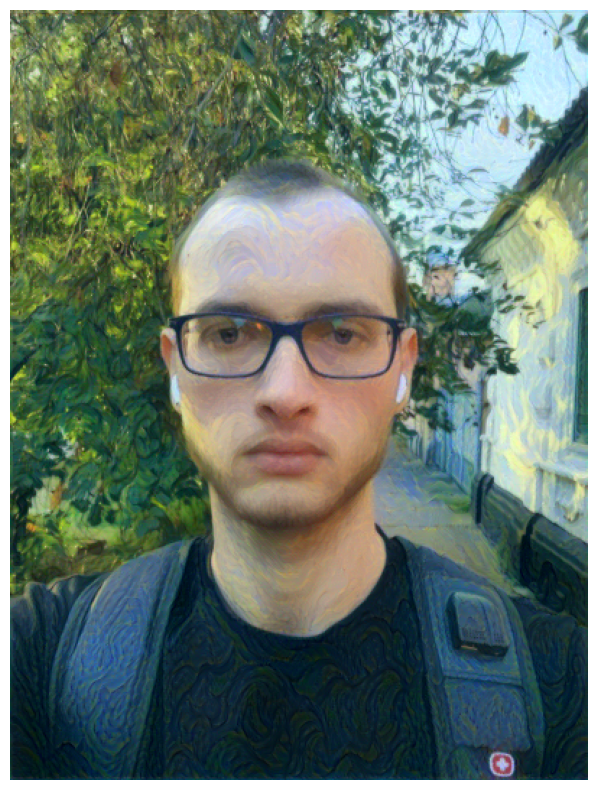

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    size = max_size if max(image.size) > max_size else max(image.size)
    if shape:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = in_transform(image).unsqueeze(0)
    return image

def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    return image

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.model = models.vgg19(pretrained=True).features.eval()
        self.selected_layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2'}

    def forward(self, x):
        features = {}
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in self.selected_layers:
                features[self.selected_layers[name]] = x
        return features

def content_loss(target, content):
    return torch.mean((target - content)**2)

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

def style_loss(target_features, style_grams):
    loss = 0
    for layer in style_grams:
        target_gram = gram_matrix(target_features[layer])
        _, d, h, w = target_features[layer].size()
        loss += torch.mean((target_gram - style_grams[layer])**2) / (d * h * w)
    return loss

def run_style_transfer(content_path, style_path, iterations=500, alpha=0.05, beta=0.4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    content = load_image(content_path).to(device)
    style = load_image(style_path, shape=content.shape[-2:]).to(device)
    target = content.clone().requires_grad_(True).to(device)

    model = VGG().to(device)

    optimizer = optim.Adam([target], lr=0.003)

    style_features = model(style)
    content_features = model(content)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    for i in range(iterations):
        optimizer.zero_grad()
        target_features = model(target)
        c_loss = content_loss(target_features['conv4_2'], content_features['conv4_2'])
        s_loss = style_loss(target_features, style_grams)
        total_loss = alpha * c_loss + beta * s_loss

        total_loss.backward(retain_graph=True)
        optimizer.step()

        if i % 50 == 0:
            print(f"Iteration {i}/{iterations}, Total Loss: {total_loss.item()}")

    return target


content_image_path = '/content/photo_2024-11-16_09-03-27.jpg'
style_image_path = '/content/R.jpg'

output = run_style_transfer(content_image_path, style_image_path)
output_image = im_convert(output)

plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()
